# STAC Data Loader

This uses the generic `pystac_client` interface to query the Microsoft Planetary Computer STAC API.
On this server, a collection of Land-Cover annotated Landsat imagery provided by Natural Resources Canada (NRCan) is available.
The images are represented by Cloud-Optimized GeoTiff (COG), and hosted on AWS NRCan servers.

We query this collection with relevant filters, and then load them using `torchdata` `DataPipe`.
The advantage of this iterator wrapper, contrary to a custom `torch` `Dataset` class, is that it allows
chaining transformation operations and aggregating the results with other datasets, which could make use of
different APIs to retrieve data, distinct CRS, and specific transformations. If additional pre-processing
becomes necessary for a given data source, we won't need to extend a derived `Dataset` class. Instead, we
will be able to _**pipe**_ the data between each necessary transformation handler.

In [136]:
from datetime import datetime, timezone

import matplotlib.pyplot as plt
import matplotlib.patches as ptc
import numpy as np
import pystac_client
import planetary_computer
import rasterio
import rioxarray
import torchdata
from rasterio.crs import CRS
from rasterio.warp import transform_bounds
from torchgeo.datasets.utils import BoundingBox

## Define our search criteria to query the STAC API

When working with STAC API, requested bounding boxes must be defined in CRS EPSG:4326.
We must convert our reference coordinates (obtained from the Planetary Computer explorer) to obtain results.
Time zones must also be considered when specifying the date-time interval.

Just to make sure we cover some interesting locations with a lot of land-cover class variation (cities, forest, etc.),
we combine two bounding boxes (union with the `|` operator) to query anything at intersects with any of them.

In [137]:
stac_url = "https://planetarycomputer.microsoft.com/api/stac/v1"

# land-cover data from NRCan in Planetary-Computer
# examples:
#   - https://planetarycomputer.microsoft.com/api/stac/v1/collections/nrcan-landcover/items/CAN_LC_2015_CAL_13_15
col = ["nrcan-landcover"]
toi = [
    datetime(2015, 1, 1, tzinfo=timezone.utc),
    datetime(2020, 2, 1, tzinfo=timezone.utc),
]
crs_epsg3978 = CRS.from_string("EPSG:3978")  # noqa
crs_epsg4326 = CRS.from_string("EPSG:4326")  # noqa
# Québec, Canada - Surrounding Montréal and part of Vermont/New-Hampshire, USA
aoi_mtl_epsg3978 = [1600390, -285480, 1900420, 14550]
aoi_mtl_epsg4326 = transform_bounds(crs_epsg3978, crs_epsg4326, *aoi_mtl_epsg3978)
# Québec, Québec City
aoi_qcc_epsg3978 = [1600390, 14550, 1900420, 314580]
aoi_qcc_epsg4326 = transform_bounds(crs_epsg3978, crs_epsg4326, *aoi_qcc_epsg3978)
# BoundingBox has 6 values to allow min/max timestamps
# Pad them temporarily as those are not necessary since STAC API use a distinct parameter for the date-time range.
aoi = BoundingBox(*aoi_mtl_epsg4326, 0, 0) | BoundingBox(*aoi_qcc_epsg4326, 0, 0)
aoi = aoi[0:4]

print("COL", col)
print("AOI", aoi)
print("TOI", toi)

COL ['nrcan-landcover']
AOI [-75.07114770152648, 45.78709476560495, -70.27246298119879, 49.259836926058874]
TOI [datetime.datetime(2015, 1, 1, 0, 0, tzinfo=datetime.timezone.utc), datetime.datetime(2020, 2, 1, 0, 0, tzinfo=datetime.timezone.utc)]


## Perform the query and validate we found some matches

In [138]:
catalog = pystac_client.Client.open(stac_url)
label_items = catalog.search(
    limit=10,  # this is a paging query parameter, not 'max_items'
    bbox=aoi,
    datetime=toi,
    collections=col,
)
found_label_items = list(label_items.items())
found_label_items

[<Item id=CAN_LC_2015_CAL_14_15>,
 <Item id=CAN_LC_2015_CAL_14_14>,
 <Item id=CAN_LC_2015_CAL_13_16>,
 <Item id=CAN_LC_2015_CAL_13_15>,
 <Item id=CAN_LC_2015_CAL_13_14>,
 <Item id=CAN_LC_2015_CAL_12_15>,
 <Item id=CAN_LC_2015_CAL_12_14>]

View the classes available on this land-cover imagery.
The classes are defined using the [STAC Label extension](https://github.com/stac-extensions/label) with the `label:classes` property.
There are many other properties available, but we don't use them for this example.

**Note**
Although the list of class names are provided by `label:classes`, we cannot rely on this information about the pixel values!
Effectively, the `file:values` property tells us that pixel values are not defined with continuous numbers.
Make sure to always check the property values and explore STAC Asset fields to identify potential mapping issues such as this one.

In [139]:
classes = found_label_items[0].properties["label:classes"]
classes

[{'name': '',
  'classes': ['Temperate or sub-polar needleleaf forest',
   'Sub-polar taiga needleleaf forest',
   'Temperate or sub-polar broadleaf deciduous forest',
   'Mixed forest',
   'Temperate or sub-polar shrubland',
   'Temperate or sub-polar grassland',
   'Sub-polar or polar shrubland-lichen-moss',
   'Sub-polar or polar grassland-lichen-moss',
   'Sub-polar or polar barren-lichen-moss',
   'Wetland',
   'Cropland',
   'Barren lands',
   'Urban',
   'Water',
   'Snow and Ice']}]

In [140]:
xfields = found_label_items[0].assets["landcover"].extra_fields
cls_map = {value["values"][0]: value["summary"] for value in xfields["file:values"]}
cls_map

{1: 'Temperate or sub-polar needleleaf forest',
 2: 'Sub-polar taiga needleleaf forest',
 5: 'Temperate or sub-polar broadleaf deciduous forest',
 6: 'Mixed forest',
 8: 'Temperate or sub-polar shrubland',
 10: 'Temperate or sub-polar grassland',
 11: 'Sub-polar or polar shrubland-lichen-moss',
 12: 'Sub-polar or polar grassland-lichen-moss',
 13: 'Sub-polar or polar barren-lichen-moss',
 14: 'Wetland',
 15: 'Cropland',
 16: 'Barren lands',
 17: 'Urban',
 18: 'Water',
 19: 'Snow and Ice'}

## Extract the STAC Asset URLs of the target imagery

For each item, open the `landcover` asset of interest provided with this annotated imagery. Classes are applied pixel-wise.

**Note 1**
Each STAC item can define their own combination of assets.
We cannot guess automatically which one is important for each use-case.
It is up to the user to extract the relevant asset(s) that are provided by each STAC Item.

**Note 2**
The Microsoft Planetary Computer specifically requires to "sign" each URL item being queried to allow their download.
This is also something to consider when interacting various STAC APIs.
Their authentication and authorization criteria are not entirely compatible.

In [141]:
signed_label_assets = [
    planetary_computer.sign(item.assets["landcover"])
    for item in found_label_items
]

asset_href = signed_label_assets[0].href
xarray_data = rioxarray.open_rasterio(asset_href)
xarray_data

<xarray.DataArray (band: 1, y: 10001, x: 10001)>
[100020001 values with dtype=uint8]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.6e+06 1.6e+06 1.6e+06 ... 1.9e+06 1.9e+06 1.9e+06
  * y            (y) float64 1.454e+04 1.45e+04 ... -2.854e+05 -2.855e+05
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

In [142]:
signed_label_assets[0].extra_fields

{'file:size': 11068854,
 'proj:bbox': [1600390.0, -285480.0, 1900420.0, 14550.0],
 'proj:wkt2': 'PROJCRS["NAD83 / Canada Atlas Lambert",BASEGEOGCRS["NAD83",DATUM["North American Datum 1983",ELLIPSOID["GRS 1980",6378137,298.257222101,LENGTHUNIT["metre",1]]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4269]],CONVERSION["Canada Atlas Lambert",METHOD["Lambert Conic Conformal (2SP)",ID["EPSG",9802]],PARAMETER["Latitude of false origin",49,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8821]],PARAMETER["Longitude of false origin",-95,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8822]],PARAMETER["Latitude of 1st standard parallel",49,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8823]],PARAMETER["Latitude of 2nd standard parallel",77,ANGLEUNIT["degree",0.0174532925199433],ID["EPSG",8824]],PARAMETER["Easting at false origin",0,LENGTHUNIT["metre",1],ID["EPSG",8826]],PARAMETER["Northing at false origin",0,LENGTHUNIT["metre",1],ID["EPSG",8827]]],CS[Cartesian,2]

## Visualize the imagery and classes for validation.

**Note**
 USA area is not available from this data produced by Canada (`no-data` values).
 Only the Canada/Québec portion with land-cover classes is visible.

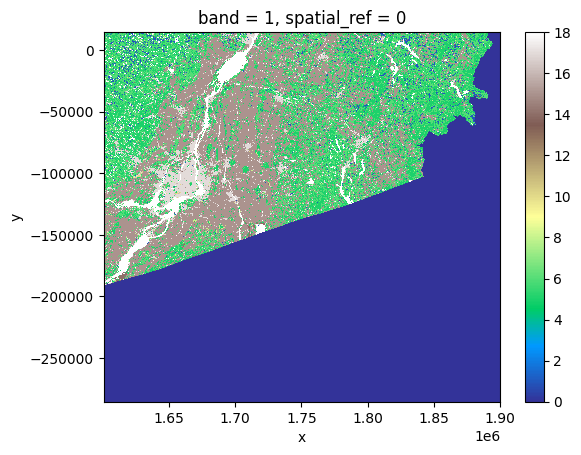

In [143]:
xarray_data.squeeze().plot.imshow(cmap="terrain")  # 'squeeze' because color is 1D (classes), not RGB(A)

In [144]:
import leafmap

lm = leafmap.Map()
lm.add_cog_layer(asset_href, opacity=0.75, colormap_name="terrain")
lm

Map(center=[20, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

## Generate image chips from our source data

Because models cannot take the full image above as input, and even less the full set of all images stitched together,
we must generate chips (a.k.a. patches or tiles) using a sliding window. Because this is a fairly common operation, we delegate
the operation to `xbatcher` which will slice the samples for us with the desired dimensions.

**Note**
It is entirely possible to extract using other approaches. The important aspect is to make it work with whichever resources
are available on your machine. Here, we extract only 1 sample for displaying it. However, you most probably will need to
generate a `batch` of samples to take advantage of GPU speedups when training a model.
For this, other parameters such as `batch_dims` can be used.
Also, it is often necessary to use some stride (overlapping tiles from the sliding window), to avoid some artifacts on tile edges.
For this, `input_overlap` can be used.

More examples available in:
- [https://xbatcher.readthedocs.io/en/latest/demo.html](https://xbatcher.readthedocs.io/en/latest/demo.html)
- [https://zen3geo.readthedocs.io/en/latest/api.html](https://zen3geo.readthedocs.io/en/latest/api.html)
- [https://zen3geo.readthedocs.io/en/latest/walkthrough.html](https://zen3geo.readthedocs.io/en/latest/walkthrough.html)

In [145]:
# WARNING: ensure this is imported, otherwise "slice_with_xbatcher" property won't be registered!
from zen3geo.datapipes import XbatcherSlicer  # noqa

xr_label_iter = [
    rioxarray.open_rasterio(
        item.href,
        default_name="label",
    )
    for item in signed_label_assets
]
dp_label = torchdata.datapipes.iter.IterableWrapper(iterable=xr_label_iter)
batch_label = dp_label.slice_with_xbatcher(input_dims={"x": 256, "y": 256})
batch_label

XbatcherSlicerIterDataPipe

In [146]:
chip = next(iter(batch_label))  # NOTE: to use as a DataLoader in a training pipeline, replace by for-loop
chip

<xarray.DataArray 'label' (band: 1, y: 256, x: 256)>
array([[[5, 5, 6, ..., 6, 5, 5],
        [5, 5, 6, ..., 6, 5, 5],
        [5, 6, 6, ..., 6, 6, 5],
        ...,
        [5, 5, 5, ..., 6, 6, 6],
        [5, 5, 5, ..., 6, 5, 5],
        [5, 5, 5, ..., 5, 5, 5]]], dtype=uint8)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 1.6e+06 1.6e+06 1.6e+06 ... 1.608e+06 1.608e+06
  * y            (y) float64 1.454e+04 1.45e+04 ... 6.915e+03 6.885e+03
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Area
    _FillValue:     0
    scale_factor:   1.0
    add_offset:     0.0

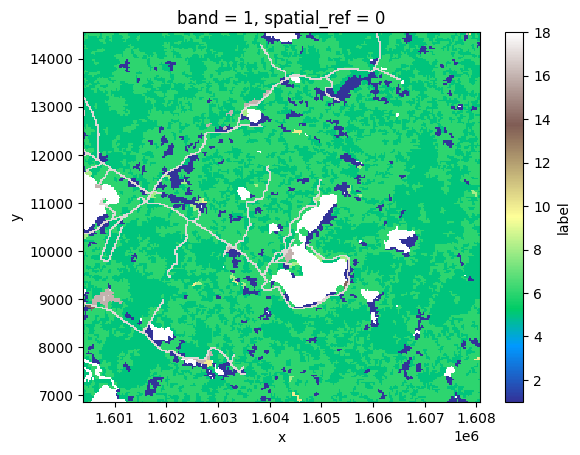

In [147]:
chip.squeeze().plot.imshow(cmap="terrain")

## Obtain non-annotated imagery data

Note that only the annotated classes were retrieved above.
If we want to use the pixel-wise labeling in a training pipeline,
we need to retrieve actual satellite imagery (without the classes) to train a model.
However, that imagery is not available within the same STAC Collection as the previous labels.

Let's retrieve some other data sources and see what we can work with.

First, let's check in more details which labels we have to better select candidate imagery.
We will use the STAC Items directly to retrieve additional metadata.

In [148]:
signed_label_items = [
    planetary_computer.sign(item)
    for item in found_label_items
]
signed_label_items

[<Item id=CAN_LC_2015_CAL_14_15>,
 <Item id=CAN_LC_2015_CAL_14_14>,
 <Item id=CAN_LC_2015_CAL_13_16>,
 <Item id=CAN_LC_2015_CAL_13_15>,
 <Item id=CAN_LC_2015_CAL_13_14>,
 <Item id=CAN_LC_2015_CAL_12_15>,
 <Item id=CAN_LC_2015_CAL_12_14>]

In [149]:
print("Items:", [item.properties["datetime"] for item in signed_label_items])
print("TOI:", [toi[0].isoformat(), toi[1].isoformat()])

Items: ['2015-01-01T00:00:00Z', '2015-01-01T00:00:00Z', '2015-01-01T00:00:00Z', '2015-01-01T00:00:00Z', '2015-01-01T00:00:00Z', '2015-01-01T00:00:00Z', '2015-01-01T00:00:00Z']
TOI: ['2015-01-01T00:00:00+00:00', '2020-02-01T00:00:00+00:00']


It seems that the land-cover labels we obtain are all from the same time in 2015.
We should probably limit our time of interest for imagery, since it is produced much more frequently.
If we don't limit the date-time range, it might be possible that things would have actually changed over time compared to our annotation.

In [150]:
landsat_collection = "landsat-c2-l2"
image_items = catalog.search(
    bbox=aoi,       # reuse the same AOI, since we are interested in the same area as previously obtained labels
    datetime=[toi[0], datetime(2015, 2, 1)],   # limit TOI since things could have changed since, we cannot rely on too recent images
    collections=[landsat_collection],
    max_items=5,    # there are much more imagery available than labels, we don't need them all for the demo
)
found_image_items = list(image_items.items())
found_image_items

[<Item id=LE07_L2SP_013028_20150131_02_T1>,
 <Item id=LE07_L2SP_013027_20150131_02_T1>,
 <Item id=LE07_L2SP_013026_20150131_02_T1>,
 <Item id=LC08_L2SP_014028_20150130_02_T2>,
 <Item id=LC08_L2SP_014027_20150130_02_T2>]

In [151]:
[item.properties["datetime"] for item in found_image_items]

['2015-01-31T15:30:46.348896Z',
 '2015-01-31T15:30:22.467161Z',
 '2015-01-31T15:29:58.586193Z',
 '2015-01-30T15:38:14.051320Z',
 '2015-01-30T15:37:50.168755Z']

In [152]:
found_image_items

[<Item id=LE07_L2SP_013028_20150131_02_T1>,
 <Item id=LE07_L2SP_013027_20150131_02_T1>,
 <Item id=LE07_L2SP_013026_20150131_02_T1>,
 <Item id=LC08_L2SP_014028_20150130_02_T2>,
 <Item id=LC08_L2SP_014027_20150130_02_T2>]

Let's consider a month interval as "close enough" for minimal changes to have happened.

Next, let's analyse our selected imagery data some more.
We can see that much more assets per STAC Item are available from the satellite imagery.

In [153]:
list(found_image_items[0].assets)

['qa',
 'ang',
 'red',
 'blue',
 'drad',
 'emis',
 'emsd',
 'lwir',
 'trad',
 'urad',
 'atran',
 'cdist',
 'green',
 'nir08',
 'swir16',
 'swir22',
 'mtl.txt',
 'mtl.xml',
 'cloud_qa',
 'mtl.json',
 'qa_pixel',
 'qa_radsat',
 'atmos_opacity',
 'tilejson',
 'rendered_preview']

## Stack the image bands

Contrary to the previous case were only a single band (land-cover classes) was extracted from STAC,
we now need to combine multiple bands represented by distinct assets into RGB images.

Because each STAC Item contains multiple bands of interest (RGB), we cannot pre-emptively
load them using `rioxarray.open_rasterio(item.href)` like we did in the case of the class labels.
Opening the files directly would generate a flat list of single channel YX grids (one per RGB band and item combination),
but we would lose the information about which one corresponds to which band and which corresponding STAC Item.
Instead, we load the items matching our search query with and stack them directly using the `assert=image_bands` criteria
to indicate to the `stack_stac_items` utility how to stack the STAC Assets (bands) stored under each respective STAC Item.

**Note 1** <br>
The selected RGB bands are chosen to facilitate the visualization as 'natural' images.
However, a model could be trained with any relevant combination of bands, as long as the
model architecture allows the corresponding input dimensions according to the generated stack.

**Note 2** <br>
In this case, we just so happen to be using Landsat imagery and land-cover data that originates from the same source.
Therefore, both are already aligned with 30m spatial resolution.
If other data sources were used with mismatching resolutions, it would be very important to resample them
in order to align the layers them along the `x` and `y` axes. The same applies for the corresponding `CRS`
of each source. Transformations need to be applied to reproject the bands along equivalent coordinates.
In general, one should provide the information whenever possible to allow the various stacking utilities to
detect discrepancies between the layers to apply necessary corrections (e.g.: using `dataarray.rio.reproject`).

In [154]:
label_info = signed_label_assets[0].extra_fields["raster:bands"][0]
resolution = label_info["spatial_resolution"]
resolution  # meters

30

In [155]:
# WARNING: ensure this is imported, otherwise "stack_stac_items" property won't be registered!
from zen3geo.datapipes import StackSTACStacker  # noqa

image_bands = ["red", "blue", "green"]
signed_image_items = [
    planetary_computer.sign(item)
    for item in found_image_items
]

dp_image = torchdata.datapipes.iter.IterableWrapper(iterable=[signed_image_items])
stack_image = dp_image.stack_stac_items(
    assets=image_bands,
    epsg=32619,  # expected CRS, will be useful to transform later when combining with labels that use a different CRS
    resolution=resolution,  # resample image (as necessary) to eventually align with previously collected labels
)
stack_image

StackSTACStackerIterDataPipe

## Visualize the obtained imagery stack

Note that the generated batch is now stacked on the `band` axis with the 3 selected bands.
Because samples were acquired at different times, the `time` axis contains as many samples and our initial `max_items` search query.
The `x` and `y` axis (the imagery) are extended to span across all the collected data.

In [156]:
image = next(iter(stack_image))  # NOTE: to use as a DataLoader in a training pipeline, replace by for-loop
image

<xarray.DataArray 'stackstac-b07b107c3955c391179853ee308377ca' (time: 5,
                                                                band: 3,
                                                                y: 18226,
                                                                x: 15298)>
dask.array<fetch_raster_window, shape=(5, 3, 18226, 15298), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/27)
  * time                         (time) datetime64[ns] 2015-01-30T15:37:50.16...
    id                           (time) <U31 'LC08_L2SP_014027_20150130_02_T2...
  * band                         (band) <U5 'red' 'blue' 'green'
  * x                            (x) float64 7.119e+04 7.122e+04 ... 5.301e+05
  * y                            (y) float64 5.526e+06 5.526e+06 ... 4.979e+06
    landsat:wrs_row              (time) <U3 '027' '028' '026' '027' '028'
    ...                           ...
    gsd                          int64 30
    landsat:collection_category  (time) <U2 'T2' 'T2' 'T1' 'T1' 'T1'
    landsat:cloud_cover_land     (time) float64 99.92 99.98 3.0 2.0 4.0
    title                        (band) <U10 'Red Band' 'Blue Band' 'Green Band'
    raster:bands                 object {'scale': 2.75e-05, 'nodata': 0, 'off...
    epsg                         int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(71190, 4978950, 530130, 55257...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 71190.00|\n| 0.00,-30.00, 5525730.00|\n| 0.00...
    resolution:  30

## Combine the images with the annotations into a Dataset

Now that we have both references, we need to combine the imagery with the labels using the corresponding coordinates
from the two collections. This will allow us to define a training pipeline were the model receives the input imagery,
and attempts to learn predicting the target labels.

First, let's create a stack of the labels.
To make sure that all the necessary metadata is provided (such that the data can be transformed as necessary when combining the two sources), we will do as for the image's case, and pass the STAC Items directly (instead of the URLs).

In [157]:
dp_label = torchdata.datapipes.iter.IterableWrapper(iterable=[signed_label_items])
stack_label = dp_label.stack_stac_items(
    assets=["landcover"],
    epsg=32619,
    resolution=resolution,
)
stack_label

StackSTACStackerIterDataPipe

We can see below that the `time` axis indicates more than one entry.
However, we found out before that the land-cover labels are all from the same time (when they were uploaded).
Actually, this "`time`" represent the different regions (or tiles) represented by each respective STAC Item that were found. 

Also, we can see that the `y`, `x` axes were extended to span over all these tiles combined.

In [158]:
next(iter(stack_label))

TIFFFillStrip: Read error at scanline 4294967295; got 0 bytes, expected 84820.
TIFFFillStrip: Read error at scanline 4294967295; got 0 bytes, expected 84820.


<xarray.DataArray 'stackstac-e6b06eff485aed3ea587d7ae15a813b3' (time: 7,
                                                                band: 1,
                                                                y: 35271,
                                                                x: 35049)>
dask.array<fetch_raster_window, shape=(7, 1, 35271, 35049), dtype=float64, chunksize=(1, 1, 1024, 1024), chunktype=numpy.ndarray>
Coordinates: (12/21)
  * time               (time) datetime64[ns] 2015-01-01 ... 2015-01-01
    id                 (time) <U21 'CAN_LC_2015_CAL_14_15' ... 'CAN_LC_2015_C...
  * band               (band) <U9 'landcover'
  * x                  (x) float64 -2.594e+05 -2.594e+05 ... 7.92e+05 7.92e+05
  * y                  (y) float64 5.859e+06 5.858e+06 ... 4.8e+06 4.8e+06
    label:properties   object None
    ...                 ...
    label:tasks        <U14 'classification'
    start_datetime     <U20 '2015-01-01T00:00:00Z'
    end_datetime       <U20 '2020-01-01T00:00:00Z'
    proj:shape         object {10001}
    raster:bands       object {'nodata': 0, 'sampling': 'area', 'data_type': ...
    epsg               int64 32619
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(-259410, 4800390, 792060, 585...
    crs:         epsg:32619
    transform:   | 30.00, 0.00,-259410.00|\n| 0.00,-30.00, 5858520.00|\n| 0.0...
    resolution:  30

To simplify following steps, we will mosaic the "`time`" (tiles) into a single layer, such that the `time` axis is not a concern anymore.
Without this, we would not be able to stack imagery with the labels directly, since they technically wouldn't "align" in `time`.
Because we established that 1 month was "good enough" to consider the labels as relevant for the selected imagery time-interval,
we can stack the labels as if they apply over any `time` axis of the images.

**Note** <br>
For the most accurate training pipeline possible, or if your use case study spans over much longer date-time intervals, this should
probably not be done. Instead, you would have to "match" similar imagery and labels along the `y`, `x` and `time` axes to form a
relevant dataset.

In [159]:
# WARNING: ensure this is imported, otherwise "mosaic_dataarray" property won't be registered!
from zen3geo.datapipes import StackSTACMosaicker  # noqa

stack_label_mosaic = stack_label.mosaic_dataarray(nodata=0)
stack_label_mosaic

StackSTACMosaickerIterDataPipe

Now, let's combine the images and the labels to form a dataset.
They must be joined together to work on both at the same time (some form of super-stack `tuple` of `DataArray`).

However, even if we previously got rid of the `time` constraint on our labels, the `y`,`x` axes still need to align
(i.e.: for each `(y,x)` location, we need both RGB pixel values and a class label).

Effectively, our queried STAC Items all intersect with our initial AOI requirement, but this does not guarantee that all the
image bands and the land-cover band will align "perfectly", depending on where the satellite passed, which tiles were retrieved
and which labels were provided in the annotation. We need to collate the data for regions that intersects both images and labels.

In [160]:
dp_image_label = stack_image.zip(stack_label_mosaic)
dp_image_label

ZipperIterDataPipe

In [215]:
import xarray as xr

def collate_image_label(data) -> xr.Dataset:
    img, lbl = data
    r = img.sel(band="red", drop=True)
    g = img.sel(band="green", drop=True)
    b = img.sel(band="blue", drop=True)
    c = lbl.sel(band="landcover", drop=True)
    merged = xr.merge(
        objects=[r, g, b, c],
        join="inner",   # because images with labels or vice-versa are useless for training, only keep the intersection
        compat="override",  # because different stacks define distinct variables, simply drop mismatching ones
        combine_attrs="drop_conflicts",  # do the same for additional attribues that don't match
    )
    return merged

In [162]:
dataset_image_label = dp_image_label.collate(collate_fn=collate_image_label)
dataset_image_label

CollatorIterDataPipe

Let's verify a sample to make sure the combined result makes sense.
Since the `crs` and the `resolution` items are still in the `attributes`, that means they align in all bands (they were not dropped).

In [163]:
dataset = next(iter(dataset_image_label))
dataset

TIFFFillStrip: Read error at scanline 4294967295; got 0 bytes, expected 84820.
TIFFFillStrip: Read error at scanline 4294967295; got 0 bytes, expected 84820.


<xarray.Dataset>
Dimensions:                      (time: 5, x: 15298, y: 18226)
Coordinates: (12/36)
  * time                         (time) datetime64[ns] 2015-01-30T15:37:50.16...
  * x                            (x) float64 7.119e+04 7.122e+04 ... 5.301e+05
  * y                            (y) float64 5.526e+06 5.526e+06 ... 4.979e+06
    id                           (time) <U31 'LC08_L2SP_014027_20150130_02_T2...
    landsat:wrs_row              (time) <U3 '027' '028' '026' '027' '028'
    landsat:wrs_path             (time) <U3 '014' '014' '013' '013' '013'
    ...                           ...
    label:type                   <U6 'raster'
    label:classes                object {'name': '', 'classes': ['Temperate o...
    label:tasks                  <U14 'classification'
    start_datetime               <U20 '2015-01-01T00:00:00Z'
    end_datetime                 <U20 '2020-01-01T00:00:00Z'
    proj:shape                   object {10001}
Data variables:
    R                            (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    G                            (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    B                            (time, y, x) float64 dask.array<chunksize=(1, 1024, 1024), meta=np.ndarray>
    class                        (y, x) float64 dask.array<chunksize=(171, 244), meta=np.ndarray>
Attributes:
    crs:         epsg:32619
    resolution:  30

The data should be aligned properly.
Otherwise, some corrections would have been necessary to scale or reproject 
these critical variables in order to make the (`y`, `x`, `time`) coordinates align.

However, there is still some "filling" errors. This is because of the AOI which actual data 
(not `nodata`) that do not perfectly align over the imagery and labels as previously mentioned. 
To refine our pipeline, we will have to look more deeply in the available overlapping sample areas.

As a reminder, let's see what the applied processing pipeline looks like so far.

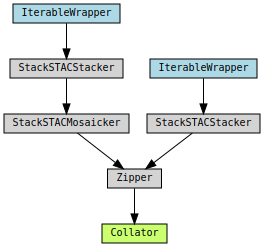

In [164]:
torchdata.datapipes.utils.to_graph(dp=dataset_image_label)

## Visualize some samples to validate

Since some portions of the AOI will fall out of the retrieved STAC Item tiles, there is a lot of `nodata` pixel values.

It is possible to filter the data to ignore `nodata` values with a simple equality check, and find exact locations. 
However, given the size of the AOI across all STAC Items, this can take quite a while to compute 
(and it does for this case over a big portion of Québec!).

Note that so far, we've been manipulating only the areas, bounds, time-intervals, etc. 
All operations were "lazy". We never filtered the values themselves, which would require pulling 
all the actual data (multiple GB).
It is faster to simply guess approximate coordinates based on the ROI hints than computing the real locations.

### Visualization

Because generating a map as a plot/figure can be tricky (need to consider RBG vs class-annotated value scaling,
overlaping multiple layers, finding \[aka *guessing*\] appropriate coordinates to find relevant data, etc.), 
and that it would only give a static result anyway, it can become very tedious to look over the sample data this way.

To help ourselves, we will instead make use of [`leafmap`](https://github.com/opengeos/leafmap) to provide a
dynamic and scalable/pannable map. It also provides a few annotation utilities which we can take advantage of.

In [190]:
import leafmap

# use 'lm.center' and 'lm.zoom' after calling it and manually adjusting to resolve future values quickly
lm = leafmap.Map(center=(48, -71), zoom=6)

for stac_item in signed_label_items:
    stac_asset = stac_item.assets["landcover"]
    lm.add_cog_layer(
        stac_asset.href,
        name=stac_item.id,
        opacity=0.5,              # allow seeing labels and imagery at the same time
        colormap_name="terrain",
        # manage ourselves with 'zoom' to obtain consistent map result across samples
        # otherwise, subsequent 'add_cog_layer' and 'add_stac_layer' causes a messy result with last iteration
        zoom_to_layer=False,
    )

for stac_item in signed_image_items:
    stac_item_link = signed_image_items[0].get_single_link("self")
    lm.add_stac_layer(
        # titiler_endpoint override is needed to avoid argument handling errors
        # (see https://github.com/opengeos/leafmap/issues/448)
        titiler_endpoint="planetary-computer",
        collection=landsat_collection,
        item=stac_item.id,
        name=stac_item.id,
        bands=image_bands,
        # let internal STAC/COG image scaling values auto-resolve,
        # otherwise LeftMap's uses Percentile 2%/98% which produces invalid values for RGB
        unscale="true",
        opacity=0.75,      # allow seeing labels and imagery at the same time
        fit_bounds=False,  # manage ourselves with 'zoom' to obtain consistent map result across samples
    )
#     lm.add_cog_layer(stac_item_link.href, name=stac_item.id, opacity=0.5, bands=image_bands)
#     for band in image_bands:
#         stac_asset = stac_item.assets[band]
#         lm.add_stac_layer(stac_asset.href, name=f"{stac_item.id}_{band}", opacity=0.5)
#         lm.add_cog_layer(stac_asset.href, name=f"{stac_item.id}_{band}", opacity=0.5, colormap_name="terrain")

lm

Map(center=[48, -71], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_te…

Using the above interactive map and the drawing utilities, it is possible to define a GeoJSON MultiPolygon that
overlaps our training labels and the available imagery. The result is obtained afterwards by saving the result.

For reference, here is what a valid area containing labels and imagery could look like.

**Note** <br>
Using Multi-Polygon features can complicate the filtering process later on when defining a dataloader 
(since Tensors will have to work with square/cube blocks). 
To simplify things, consider defining multiple distinct data-pipes (i.e: using `torchdata.datapipes.iter.Forker`)
each processing a specific Polygon with a square area, and then concatenating (i.e.: `torchdata.datapipes.iter.Zipper`)
those data-pipes into a single dataset.

![preview](../images/preview-stac-label-image-bbox.png)

In [166]:
lm.save_draw_features("../data/annotations.geojson")

### Filtering Region of Interest

Instead of the above Multi-Polygon, the below sample bounding box is used for the rest of the demo.

In [168]:
import json

with open("../data/annotations.geojson", mode="r", encoding="utf-8") as annot_f:
    annot_geojson = json.load(annot_f)

annot_geom = annot_geojson.get("geometry") or annot_geojson.get("features", [{}])[0].get("geometry")
assert annot_geom, "Missing bounding box to resume. Either define it in 'annotations.geojson' or via the 'leafmap' utility."
annot_geojson

{'type': 'FeatureCollection',
 'features': [{'type': 'Feature',
   'properties': {},
   'geometry': {'type': 'Polygon',
    'coordinates': [[[-73.289725, 46.403524],
      [-73.289725, 48.147519],
      [-70.366764, 48.147519],
      [-70.366764, 46.403524],
      [-73.289725, 46.403524]]]}}]}

In [169]:
from shapely.geometry import shape

annot_limit = shape(annot_geom)
annot_bounds = annot_limit.bounds
annot_bounds

(-73.289725, 46.403524, -70.366764, 48.147519)

In [170]:
from shapely import to_geojson, Polygon

annot_bbox = json.loads(to_geojson(Polygon.from_bounds(*annot_bounds)))
annot_bbox

{'type': 'Polygon',
 'coordinates': [[[-73.289725, 46.403524],
   [-73.289725, 48.147519],
   [-70.366764, 48.147519],
   [-70.366764, 46.403524],
   [-73.289725, 46.403524]]]}

In [171]:
lm.add_geojson(
    annot_bbox, 
    layer_name="Bounding Box",
)
lm

Map(bottom=5695.0, center=[48, -71], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title…

Now that we have found a valid region, let's filter the data-pipe to limit it only to valid samples.

Since we will work with a subset of the previously defined stacks, 
we will redefine them from scratch to ensure they are properly defined.

We will also reuse previously defined functions to show the full pipeline in a concise manner below.

**Note** <br>
Because the computed `annot_bounds` uses `EPSG:4326` (i.e.: coordinates in degrees), it is important to pass them to
`stack_stac_items` (which itself passes it to [`stackstac.stack`](https://stackstac.readthedocs.io/en/latest/api/main/stackstac.stack.html))
using the `bounds_latlon` parameter (and not `bounds`)! The `bounds` parameter assumes they are in the same coordinate system as specified
by the `epsg` parameter, which is `EPSG:32619` is the case of our sample imagery and labels.

In [216]:
dp_label = torchdata.datapipes.iter.IterableWrapper(iterable=[signed_label_items])
stack_label = dp_label.stack_stac_items(
    assets=["landcover"],
    epsg=32619,
    resolution=resolution,
    bounds_latlon=annot_bounds,  # this is the new parameter from our valid area with imagery+labels
)
stack_label_mosaic = stack_label.mosaic_dataarray(nodata=0)

dp_image = torchdata.datapipes.iter.IterableWrapper(iterable=[signed_image_items])
stack_image = dp_image.stack_stac_items(
    assets=image_bands,
    epsg=32619,
    resolution=resolution,
    bounds_latlon=annot_bounds,  # this is the new parameter from our valid area with imagery+labels
)

dp_image_label = stack_image.zip(stack_label_mosaic)
dataset_image_label = dp_image_label.collate(collate_fn=collate_image_label)
dataset_sliced = dataset_image_label.slice_with_xbatcher(input_dims={"x": 256, "y": 256})

In [200]:
next(iter(dataset_sliced))

TIFFFillStrip: Read error at scanline 4294967295; got 0 bytes, expected 84820.
TIFFFillStrip: Read error at scanline 4294967295; got 0 bytes, expected 84820.


<xarray.DataArray 'band' (band: 3)>
array(['red', 'blue', 'green'], dtype='<U5')
Coordinates:
  * band                       (band) <U5 'red' 'blue' 'green'
    landsat:correction         <U4 'L2SP'
    landsat:collection_number  <U2 '02'
    landsat:wrs_type           <U1 '2'
    description                <U28 'Landsat Collection 2 Level-2'
    view:off_nadir             int64 0
    gsd                        int64 30
    title                      (band) <U10 'Red Band' 'Blue Band' 'Green Band'
    raster:bands               object {'scale': 2.75e-05, 'nodata': 0, 'offse...
    epsg                       int64 32619


<xarray.Dataset>
Dimensions:                      (time: 5, x: 256, y: 256)
Coordinates: (12/36)
  * time                         (time) datetime64[ns] 2015-01-30T15:37:50.16...
    id                           (time) <U31 'LC08_L2SP_014027_20150130_02_T2...
  * x                            (x) float64 1.702e+05 1.703e+05 ... 1.779e+05
  * y                            (y) float64 5.342e+06 5.342e+06 ... 5.334e+06
    landsat:wrs_row              (time) <U3 '027' '028' '026' '027' '028'
    landsat:wrs_path             (time) <U3 '014' '014' '013' '013' '013'
    ...                           ...
    label:type                   <U6 'raster'
    label:classes                object {'name': '', 'classes': ['Temperate o...
    label:tasks                  <U14 'classification'
    start_datetime               <U20 '2015-01-01T00:00:00Z'
    end_datetime                 <U20 '2020-01-01T00:00:00Z'
    proj:shape                   object {10001}
Data variables:
    R                            (time, y, x) float64 nan nan nan ... nan nan
    G                            (time, y, x) float64 nan nan nan ... nan nan
    B                            (time, y, x) float64 nan nan nan ... nan nan
    class                        (y, x) float64 8.0 8.0 10.0 ... 18.0 1.0 1.0
Attributes:
    spec:        RasterSpec(epsg=32619, bounds=(170250, 5139780, 398340, 5341...
    crs:         epsg:32619
    transform:   | 30.00, 0.00, 170250.00|\n| 0.00,-30.00, 5341620.00|\n| 0.0...
    resolution:  30

## Define a Data Loader!

Now, for the final part, using our stack of images and labels, let's define a dataset.

In [217]:
import torch

def dataset_to_tensors(sample_chip: xr.Dataset) -> (torch.Tensor, torch.Tensor):
    img: torch.Tensor = torch.as_tensor(sample_chip[image_bands].data.astype("float32"))
    lbl: torch.Tensor = torch.as_tensor(sample_chip["landcover"].data.astype("uint8"))
    return img, lbl


dataset_tensors = dataset_sliced.map(fn=dataset_to_tensors)

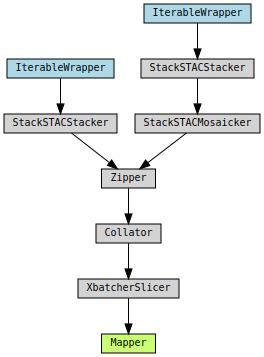

In [213]:
torchdata.datapipes.utils.to_graph(dp=dataset_tensors)

In [218]:
max_iters = 10
dataloader = torch.utils.data.DataLoader(dataset=dataset_tensors)
for i, batch in enumerate(dataloader):
    image, mask = batch
    print(f"Batch {i} - image: {image.shape}, mask: {mask.shape}")
    if i == max_iters:
        break


TIFFFillStrip: Read error at scanline 4294967295; got 0 bytes, expected 84820.
TIFFFillStrip: Read error at scanline 4294967295; got 0 bytes, expected 84820.


RuntimeError: Error reading Window(col_off=0, row_off=0, width=1024, height=1024) from 'https://nrcanlandcovereuwest.blob.core.windows.net/landcover/assets/cogs/CAN_LC_2015_CAL_13_14_cog.tif?st=2023-05-23T01%3A58%3A56Z&se=2023-05-24T02%3A43%3A56Z&sp=rl&sv=2021-06-08&sr=c&skoid=c85c15d6-d1ae-42d4-af60-e2ca0f81359b&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2023-05-24T00%3A12%3A16Z&ske=2023-05-31T00%3A12%3A16Z&sks=b&skv=2021-06-08&sig=lgVl2w8sgZY1SXqnFM4k/ORNkXVH9/5/IXNZD8F8AIQ%3D': RasterioIOError('Read or write failed. IReadBlock failed at X offset 0, Y offset 0: IReadBlock failed at X offset 18, Y offset 8: TIFFReadEncodedTile() failed.')
This exception is thrown by __iter__ of XbatcherSlicerIterDataPipe(input_dims={'x': 256, 'y': 256}, kwargs={}, source_datapipe=CollatorIterDataPipe)